## Set-up

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import os
import numpy as np
from PIL import Image
import pickle
import json
from pycocotools import mask as coco_mask
from sam4d.visualize import img_draw_masks_and_prompts, pts_draw_masks_and_prompts, sam4d_viz

### Visualizing SAM4D labels

#### Select an example data

We use data in `../data/samples/waymo` for example, please refer to **Prepare Data** in README.md to get yourself data ready.

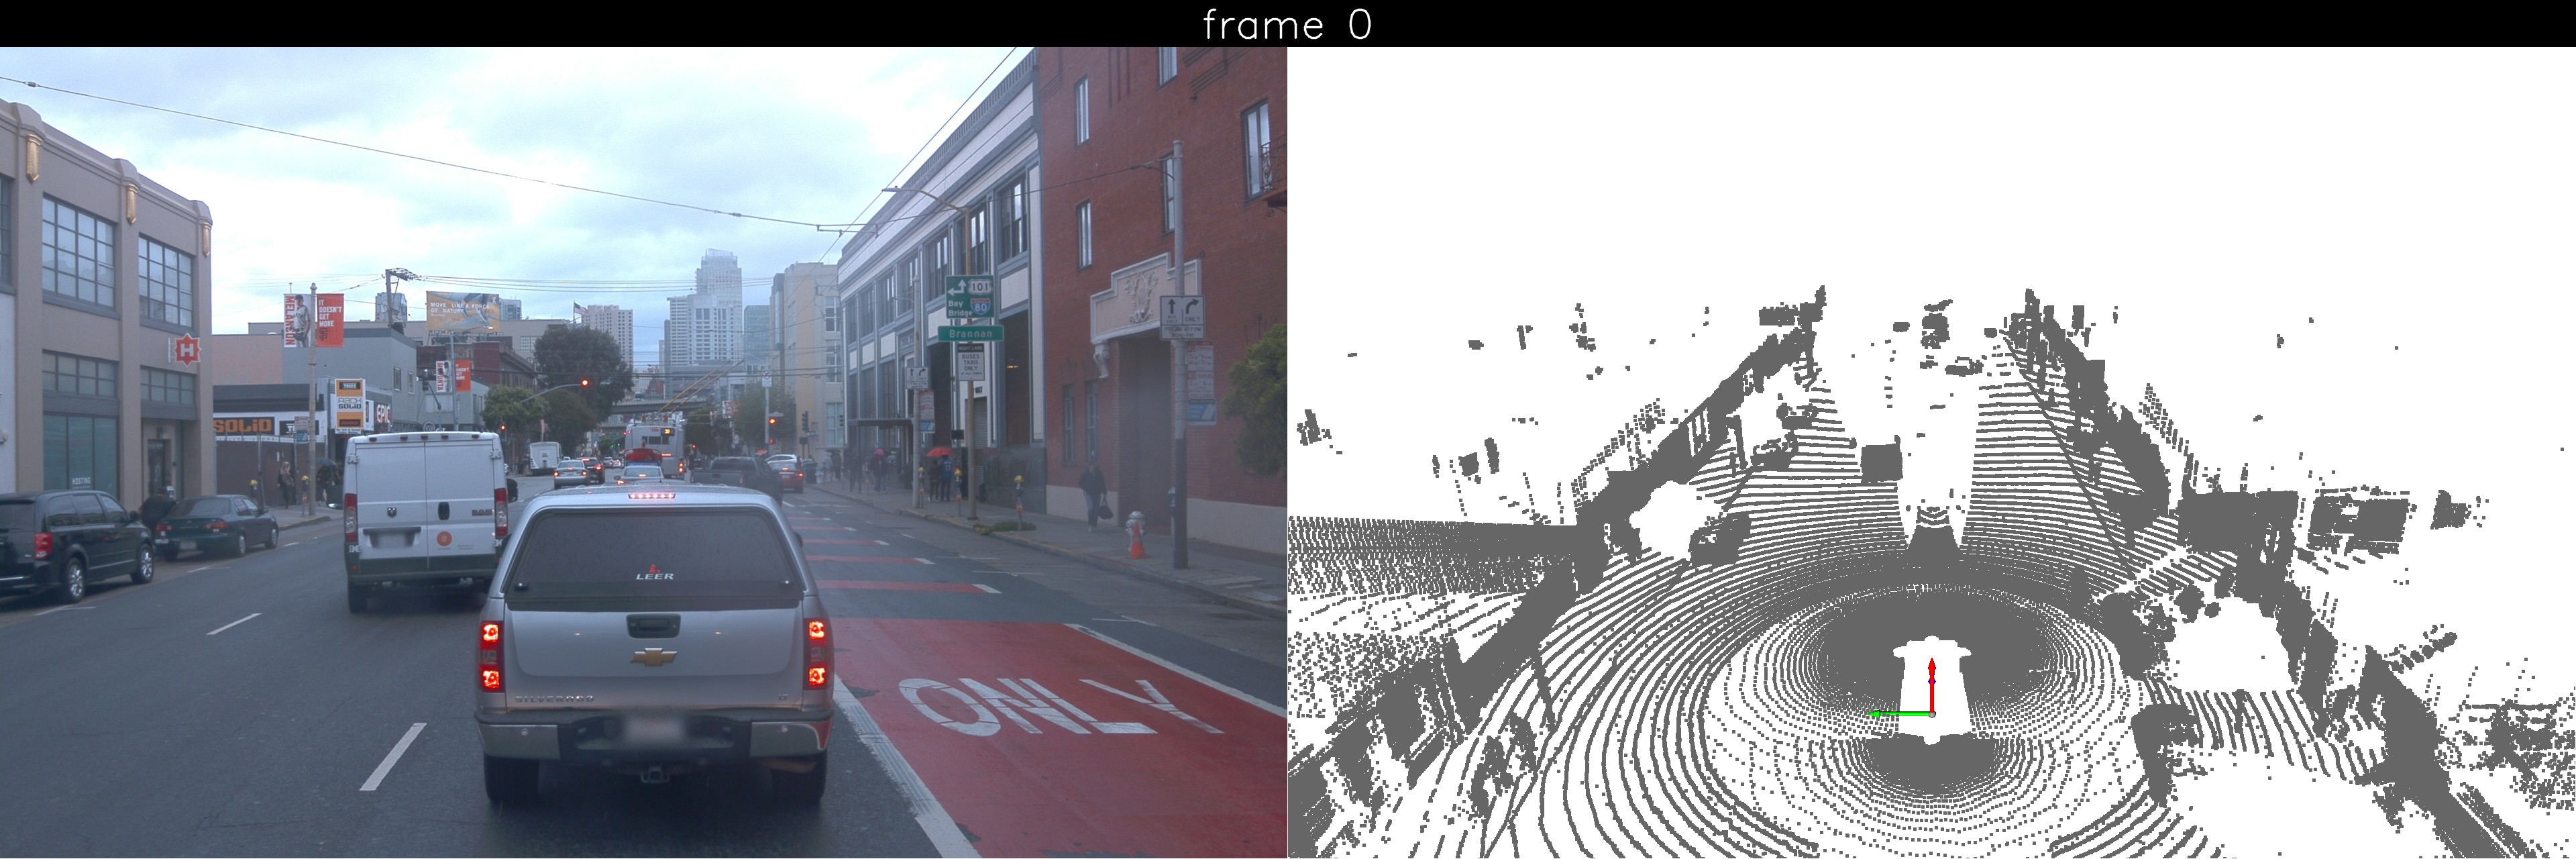

In [14]:
data_dir = "../data/samples/waymo"
seq_name = "segment-10868756386479184868_3000_000_3020_000_with_camera_labels"
cam_name = "FRONT"

with open(os.path.join(data_dir, 'meta_infos', f'{seq_name}.pkl'), 'rb') as f:
    meta_info = pickle.load(f)

# pick a frame to explore
frame_idx = 0
img_path = os.path.join(data_dir, meta_info['frames'][frame_idx]['cams_info']['FRONT']['data_path'])
pcd_path = os.path.join(data_dir, meta_info['frames'][frame_idx]['path']['pcd'])
img = np.array(Image.open(img_path))
pcd = np.load(pcd_path)['data']

frame_viz = sam4d_viz(img, pcd, title=f'frame {frame_idx}')
display(Image.fromarray(frame_viz))

#### read sam4d pesudo-labels

In [19]:
def load_sam4d_label(sam4d_label_path, filter_cfg={'score': 0, 'volume': 0},
                     cam_name='FRONT', lidar_name='LiDAR_TOP'):
    def decode_mask(encoded_mask):
        """
        Args:
            encoded_mask (dict): COCO RLE style mask。

        Returns:
            numpy.ndarray: decoded binary mask。
        """
        if not isinstance(encoded_mask, dict):
            raise ValueError("Encoded mask must be a dictionary.")

        decoded = coco_mask.decode(encoded_mask)
        return decoded

    assert sam4d_label_path.endswith('.json'), f"{sam4d_label_path} must be a json file"
    with open(sam4d_label_path) as fp:
        sam4d_raw_label = json.load(fp)

    # get obj score statistics
    total_obj_infos = {}
    tgt_sensors = [cam_name, lidar_name]
    for sensor in tgt_sensors:
        if not sensor in sam4d_raw_label['sensors']:
            continue
        for obj_info in sam4d_raw_label['sensors'][sensor]['objects']:
            if obj_info['object_id'] in total_obj_infos:
                continue
            total_obj_infos[obj_info['object_id']] = {
                'volume': obj_info.get('volume', 10),
                'score': obj_info.get('score', 0.5),
                'semantic': obj_info.get('semantic', None)}

    selected_obj_infos = {}
    for obj_id, obj_info in total_obj_infos.items():
        if obj_info['score'] > filter_cfg['score'] and obj_info['volume'] > filter_cfg['volume']:
            selected_obj_infos[obj_id] = obj_info

    if len(selected_obj_infos) == 0:
        print(f"sam4d, after filter {filter_cfg}, {sam4d_label_path} does not have any object")
        selected_obj_infos = total_obj_infos

    # load lidar mask
    lidar_info = sam4d_raw_label['sensors'][lidar_name]
    pts_instance_mask, pts_instance_ids = [], []
    pts_ignore_mask = None
    for obj_info in lidar_info['objects']:
        if obj_info['object_id'] == -1:
            pts_ignore_mask = decode_mask(obj_info['lidar_mask']).squeeze(1).astype(np.bool_)
            continue
        if not obj_info['object_id'] in selected_obj_infos:
            continue
        this_mask = decode_mask(obj_info['lidar_mask'])  # (n_pts, 1)
        pts_instance_mask.append(this_mask)
        pts_instance_ids.append(obj_info['object_id'])
    pts_instance_mask = np.concatenate(pts_instance_mask, -1).astype(np.int8)  # (n_pts, n_masks)
    if pts_ignore_mask is None:
        pts_ignore_mask = np.zeros(pts_instance_mask.shape[0], dtype=np.bool_)
    pts_instance_mask[pts_ignore_mask] = -1

    # load camera mask
    cam_info = sam4d_raw_label['sensors'][cam_name]
    img_instance_mask, img_instance_ids = [], []
    for obj_info in cam_info['objects']:
        if not obj_info['object_id'] in selected_obj_infos:
            continue
        this_mask = decode_mask(obj_info['image_mask'])  # (H, W)
        img_instance_mask.append(this_mask)
        img_instance_ids.append(obj_info['object_id'])
    img_instance_mask = np.stack(img_instance_mask, -1).astype(np.int8)  # (H, W, n_masks)
    img_instance_ids = np.array(img_instance_ids, dtype=np.int32)

    return pts_instance_mask, pts_instance_ids, img_instance_mask, img_instance_ids

In [20]:
sam4d_label_path = os.path.join(data_dir, meta_info['frames'][frame_idx]['path']['sam4d_label'])
# cfg
filter_cfg={'score': 0, 'volume': 0}
cam_name = 'FRONT'
lidar_name = 'LiDAR_TOP'

pts_instance_mask, pts_instance_ids, img_instance_mask, img_instance_ids = load_sam4d_label(sam4d_label_path, filter_cfg, cam_name, lidar_name)

#### visualize sam4d pesudo-labels

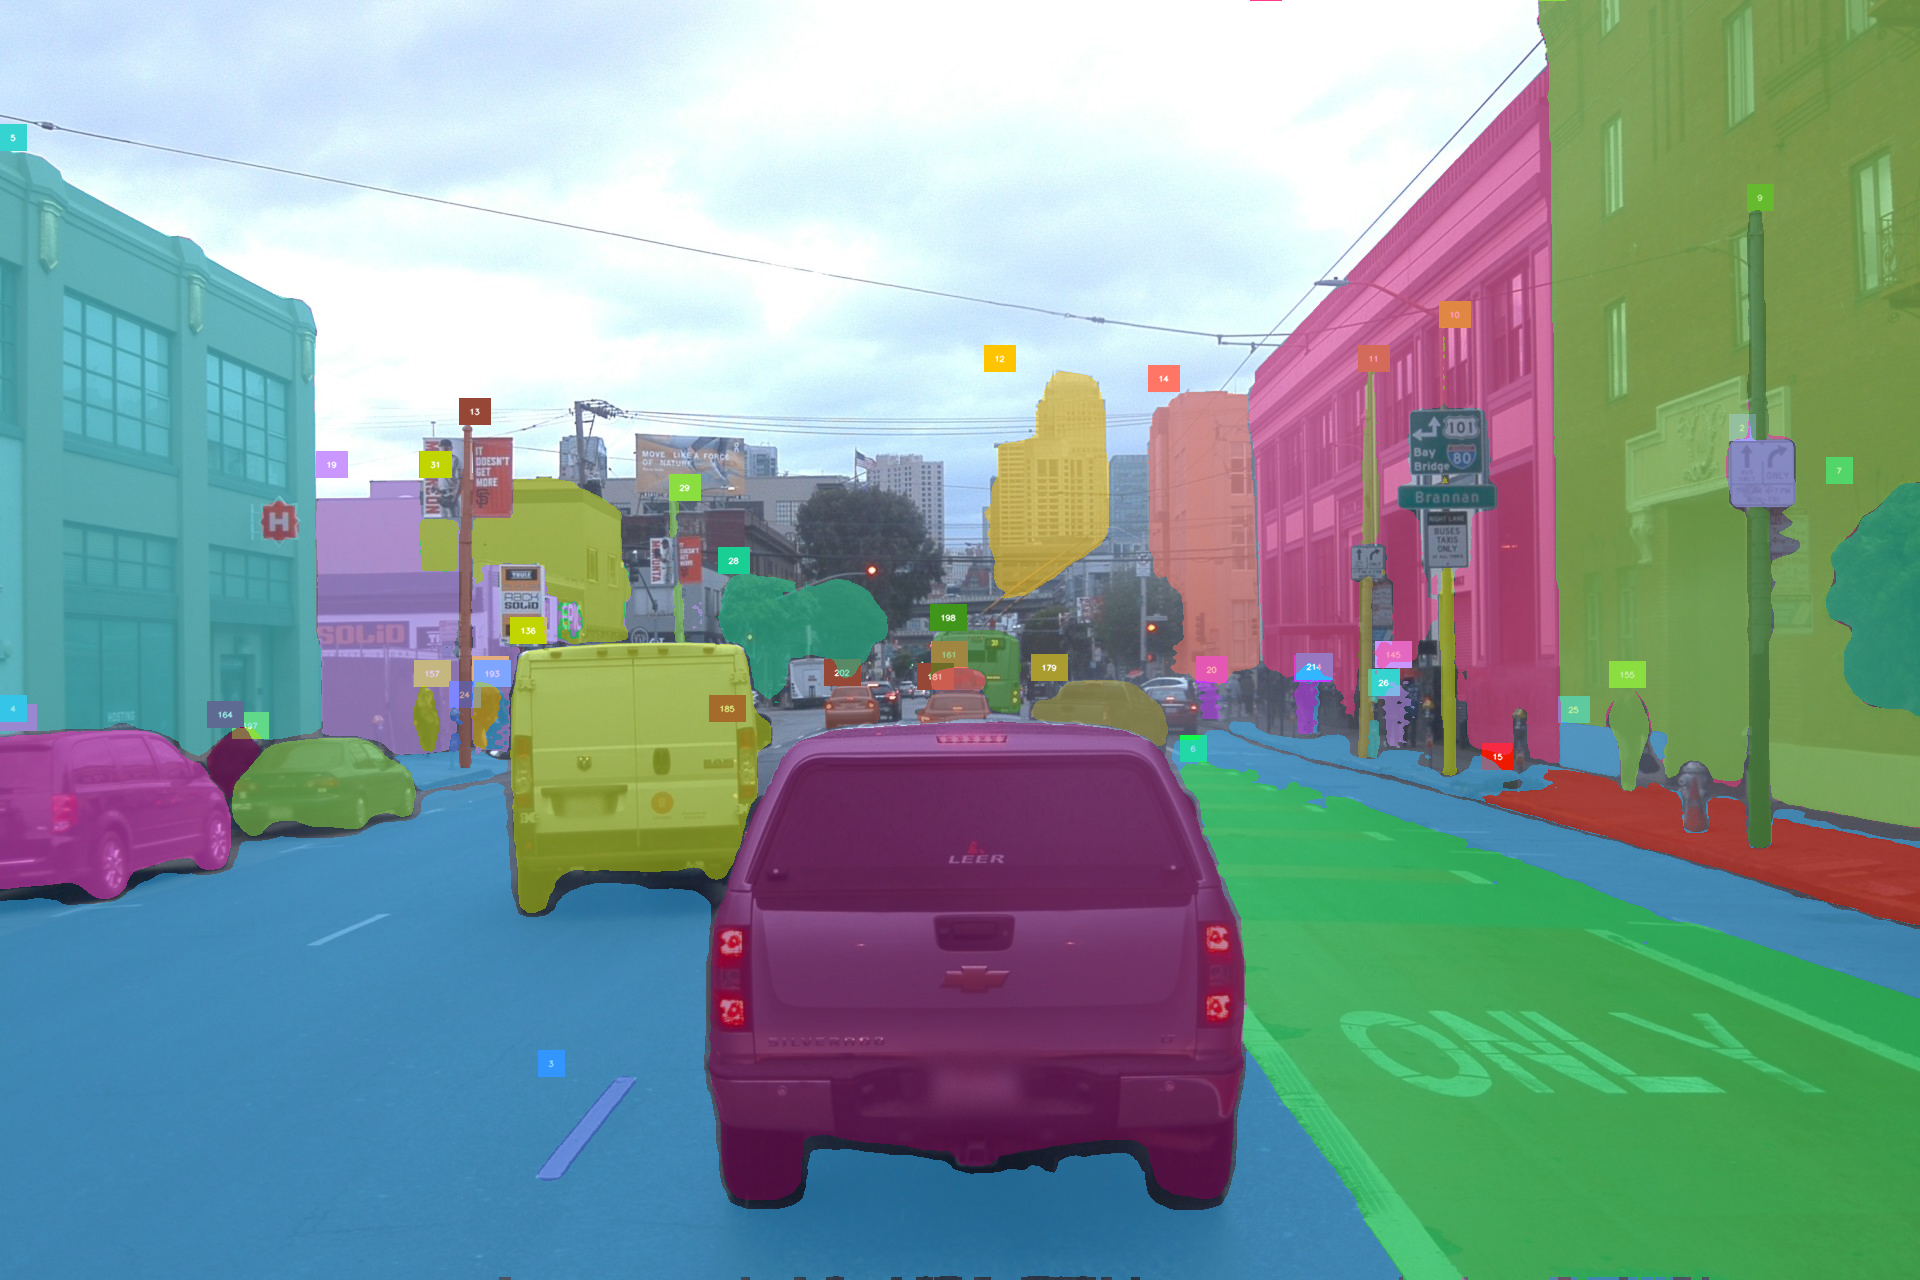

In [24]:
viz_img = img_draw_masks_and_prompts(img, img_instance_mask.transpose(2, 0, 1), img_instance_ids)
display(Image.fromarray(viz_img))

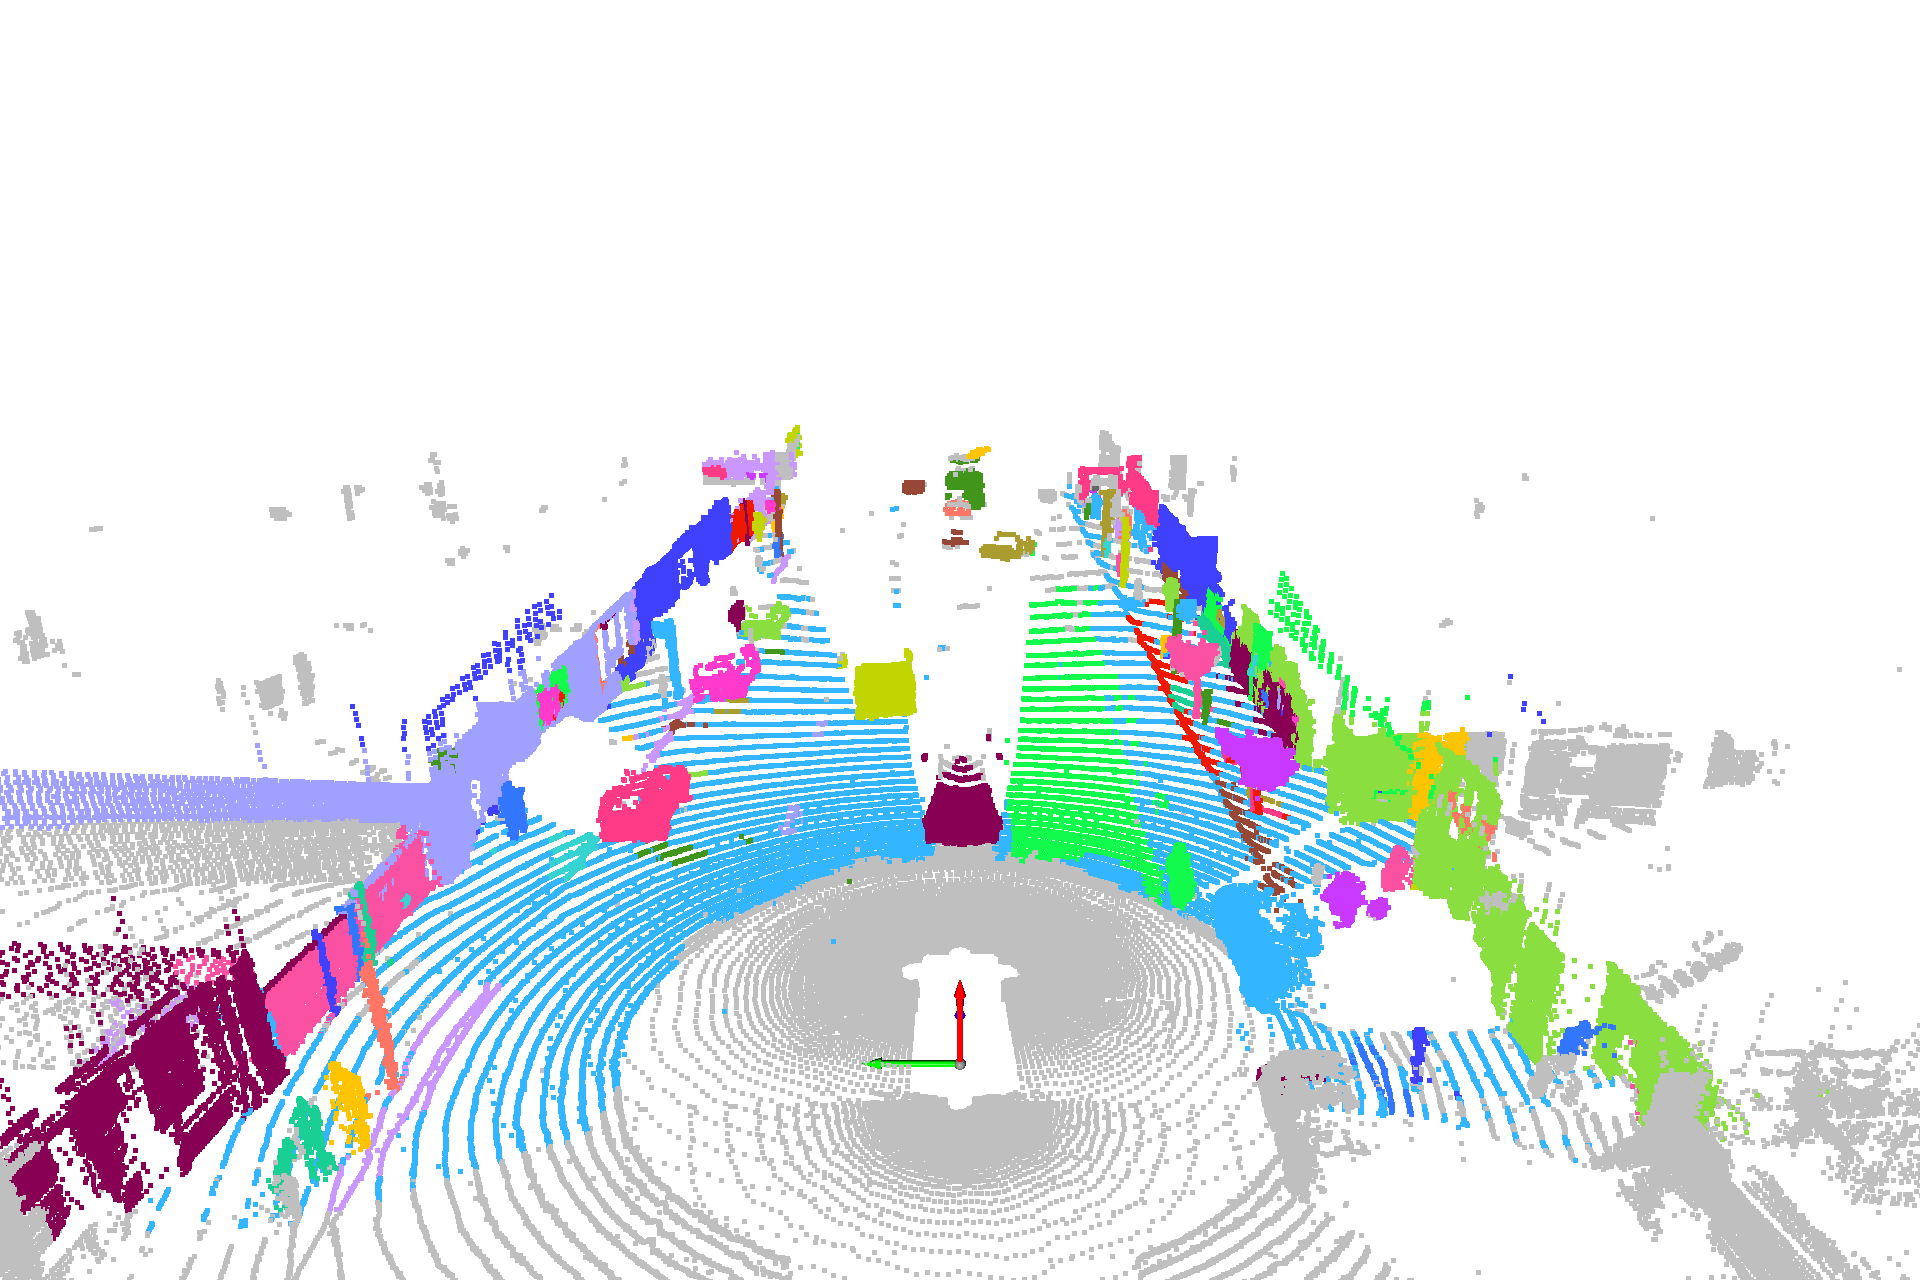

In [25]:
viz_lidar = pts_draw_masks_and_prompts(pcd, pts_instance_mask.transpose(1, 0), pts_instance_ids)
display(Image.fromarray(viz_lidar))